## Instructions
* Read each cell and implement the **TODOs** sequentially. The markdown/text cells also contain instructions which you need to follow to get the whole notebook working.
* Do not change the variable names unless the instructor allows you to.
* Do not delete the **TODO** comment blocks.
* Aside from the TODOs, there will be questions embedded in the notebook and a cell for you to provide your answer (denoted with A:). Answer all the markdown/text cells with **"A: "** on them. 
* You are expected to search how to some functions work on the Internet or via the docs. 
* You may add new cells for "scrap work".
* The notebooks will undergo a "Restart and Run All" command, so make sure that your code is working properly.
* You are expected to understand the data set loading and processing separately from this class.
* You may not reproduce this notebook or share them to anyone.

Place your answers to the questions directly inline on the same cell as **A:**

For example:

<span style='color:red'>**Question 00:**</span> What is your favorite ice cream flavor?

<span style='color:red'>**A00:**</span> My favorite flavor ice cream flavor is pistachio.

# Assignment 1.2 - Math Concepts Notebook 
In this notebook, you will be experimenting on a simplified German tank problem and a vehicle routing problem.

Learning goals:
- apply statistical estimation techniques for inferring the value of a target variable based on observed data
- apply combinatorial optimization techniques on a vehicle routing problem
- analyze how different choices of priors affect the estimates

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy

# (Probabilities) Simplified German Tank Problem

In this exercise, you will recreate the classic "German Tank Problem" that aims to estimate the total number of tanks produced based on a sample of observed serial numbers. During World War II, Allied forces faced the challenge of estimating the number of German tanks produced using only the serial numbers of captured or destroyed tanks. To solve this, they used statistical techniques to make accurate estimates with limited data. You will simulate this scenario by generating a random sample of tank serial numbers and creating a probabilistic model to estimate the total number of tanks. Then you will compare your estimates with the true total number of tanks. Through this exercise, you'll gain insights into statistical estimation techniques.

To simplify the problem, let's assume that the serial numbers are numbered in sequence and also assume that it simply is based on the count, i.e., the first tank will have a serial number of $1$, and the second will have $2$, and the $n$-th tank will have a serial number of $n$. 

Let's set the ground truth number of tanks using the variable `num_tanks`. 

In [70]:
num_tanks = 150
num_captured = 3

In [71]:
np.random.seed(0)
serial_number_captured = np.random.randint(num_tanks, size=(num_captured,)) + 1
serial_number_captured

array([ 48, 118,  68])

From this number, we can assume that we captured some amount of tanks, specified by the variable `num_captured`. These captured serial numbers will be the only basis of our estimates. 

We will be using Bayesian inference to estimate the actual number of tanks. Bayesian inference is a statistical method that updates the probability estimate for a target variable as new evidence is acquired. It begins with prior beliefs about the possible values of the variable, represented as a prior probability distribution. When new data is observed, Bayesian inference calculates the likelihood of that data given the possible values of the target variable. By combining the prior beliefs with this likelihood through Bayes' theorem, it produces a posterior distribution that reflects the updated beliefs about the target variable. This approach allows for a systematic way to incorporate both existing knowledge and new information, leading to more informed decision-making.

<center>
    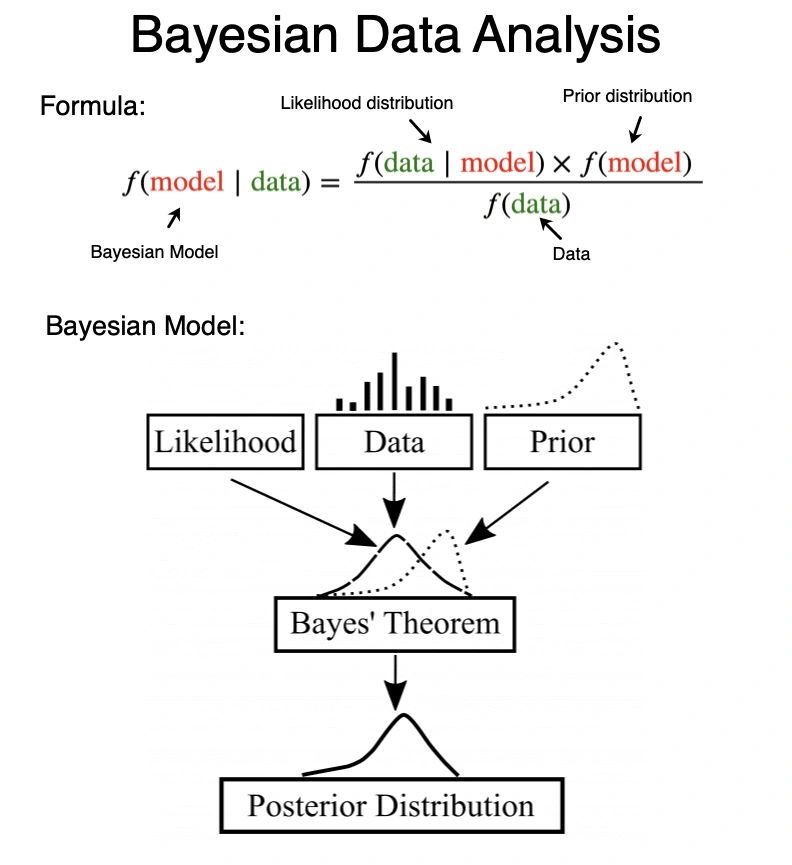
</center>

An example of Bayesian updating beliefs for a coin toss is shown below: 

<center>
    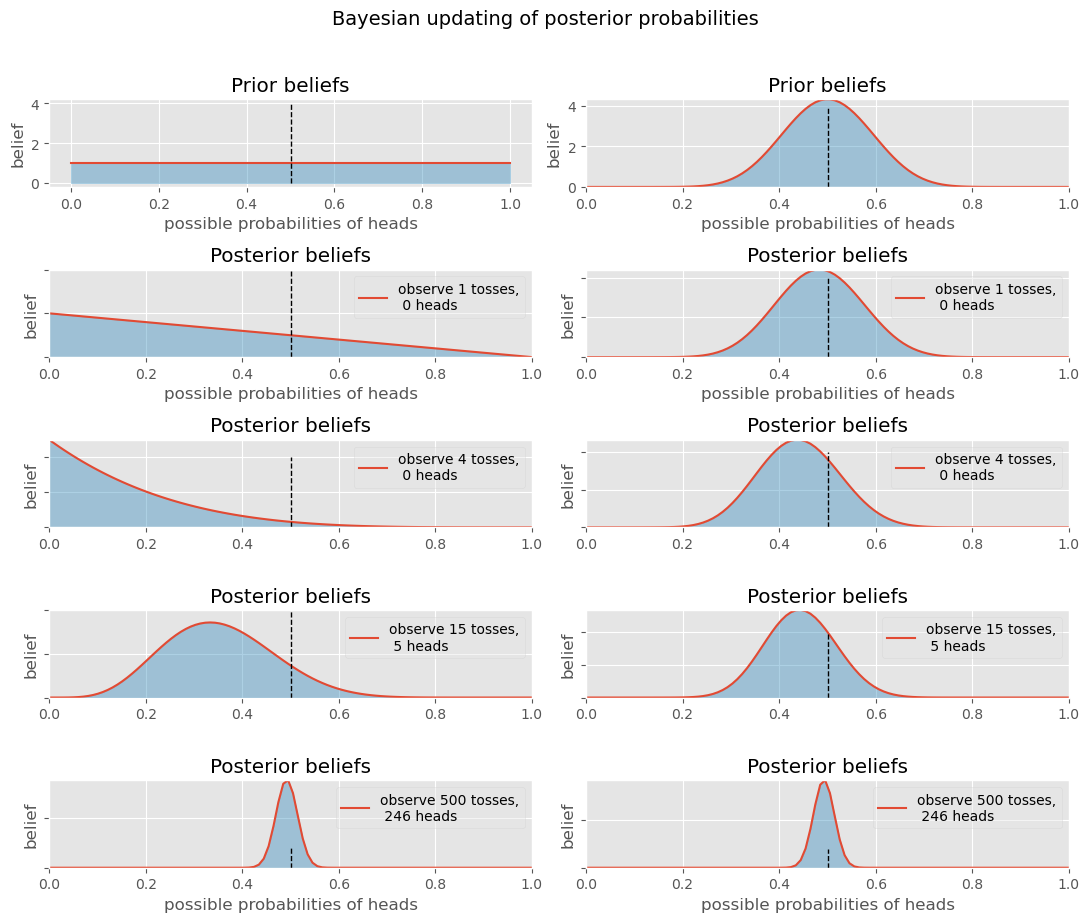
</center>

We can observe that with an uninformative uniform prior (left side), the initial observations significantly influence the beliefs. However, the initial observations are not going to be good estimates of the probability of heads because there are too few trials (tosses) done. This is emphasized in the first toss where the highest belief is on the probability of heads being 0. As we observe more tosses though (e.g. the 500 tosses example), the probabilities start to reflect the true probability of around 0.5.

Now we can compare this to the version where we use a gaussian prior centered around 0.5 as our prior (right side). This is a reasonable prior because there is a strong reason to believe that a coin is fair. We can observe that the prior has a big influence on the initial trials (tosses) and gives us a more realistic guess / estimate of the true coin probability even if there are only few observations / trials done. 

Going back to the German tank problem.

The probability that we are after is $P(N_\text{tanks} | \text{serial\_numbers})$ and from Bayes rule we know that:

$$P(N_\text{tanks} | \text{serial\_numbers}) = \frac{P(\text{serial\_numbers} | N_\text{tanks})P( N_\text{tanks})}{P(\text{serial\_numbers})}$$

- $P(N_\text{tanks} | \text{serial\_numbers})$ is called the posterior
- $P(\text{serial\_numbers} | N_\text{tanks})$ is called the likelihood
- $P( N_\text{tanks})$ is called the prior
- $P(\text{serial\_numbers})$ is called the evidence or normalizing constant

Let's first define the prior. The prior contains our beliefs on the probabilities of each of the possible number of tanks. As another simplifying assumption, we're going to limit our guesses to 500 and assume that it is impossible to make more than that because of the costs of the tank. 

We can represent the prior as an array (numpy array) that contains a probability value for every single possible number of tanks. Since we do not have any other insights for what the probabilities for the different possibilities are, we can simply assume it to be a uniform distribution. 

In [72]:
max_tanks = 500
possible_num_tanks = np.arange(max_tanks) + 1


###############################################################
# TODO-01: Compute for the prior distribution based on the    #
# description above.                                          #
###############################################################

#Since the prior distribution is uniform this means that any number is equally likely. Given that it is also a probability, we know that it must sum up to 1. Hence we have
prior = np.ones(max_tanks)/max_tanks

###############################################################
#                    End of your code.                        #
###############################################################

Let's plot the prior distribution

Text(0.5, 0, 'Possible number of tanks ($N_\\text{tanks}$)')

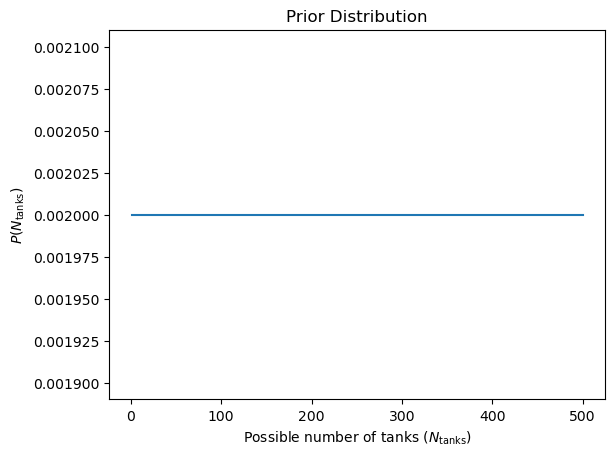

In [73]:
plt.plot(possible_num_tanks,prior)
plt.title("Prior Distribution")
plt.ylabel(r"$P(N_\text{tanks})$")
plt.xlabel(r"Possible number of tanks ($N_\text{tanks}$)")

Next, let's implement the likelihood $P(\text{serial\_numbers} | N_\text{tanks})$. Similarly, the likelihood will be represented as a numpy array that contains the likelihood probability for every possible guess of $N_\text{tanks}$. 

Let us assume first that we only observe 1 tank, we will generalize this to more observations later on.

Let's put numbers to make it more intuitive as to how we can define the values of the likelihood. Suppose we observe one tank with a serial number of $60$ and $N_\text{tanks} = 70$, what is the probability of observing a tank with serial number $60$? Assuming that there's no other factors that affect the probability, it would simply be $\frac{1}{70}$ because the serial number $60$ is just one out of the 70 tanks available. Therefore, $P(\text{serial\_numbers} = 60| N_\text{tanks} = 70) = \frac{1}{70}$. Continuing this logic, then, $P(\text{serial\_numbers} = 60| N_\text{tanks} = 80) = \frac{1}{80}$. However, we have to consider probabilities for all possible values of $N_\text{tanks}$. That includes values lower than $60$. But since we already saw a serial number with $60$, then it means that the total number of $N_\text{tanks}$ is at least 60. Therefore, we can safely assume $P(\text{serial\_numbers} = 60| N_\text{tanks} < 60) = 0$

In [74]:
###############################################################
# TODO-02: Implement the function that computes for the       #
# likelihood.                                                 #
###############################################################
def Likelihood(serial_number_captured, possible_num_tanks):
    likelihood_val = np.zeros(max_tanks)
    for N in possible_num_tanks:
        if N >= np.max(serial_number_captured):
            likelihood_val[N - 1] = 1 / N
    return likelihood_val
###############################################################
#                    End of your code.                        #
###############################################################

In [75]:
#this makes sense since it will slowly converge to 1/max_tanks as you increase N whereas it will be 0 if denominator is smaller than numerator
likelihood_output = Likelihood(serial_number_captured, possible_num_tanks)
likelihood_output

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Text(0.5, 0, 'Possible number of tanks ($N_\\text{tanks}$)')

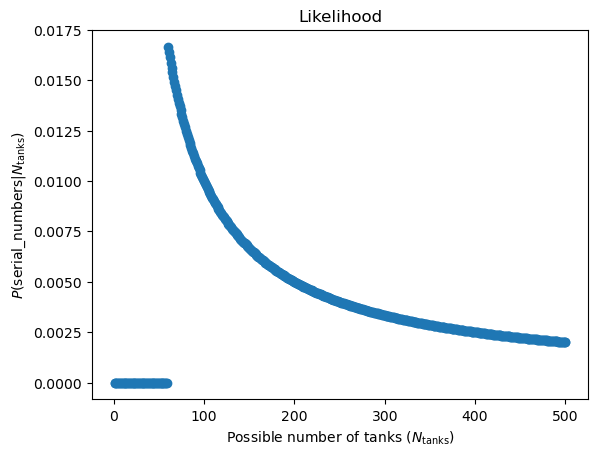

In [76]:
likelihood = Likelihood(60,possible_num_tanks)
plt.scatter(possible_num_tanks, likelihood)
plt.title("Likelihood")
plt.ylabel(r"$P(\text{serial\_numbers} | N_\text{tanks})$")
plt.xlabel(r"Possible number of tanks ($N_\text{tanks}$)")

We can now implement the posterior $P(N_\text{tanks} | \text{serial\_numbers})$ based on the Bayes rule formula defined above. Note the normalization constant is simply the sum of the numerator. As the name implies, it ensures that the values sum to one.

In [77]:
###############################################################
# TODO-03: Implement the function that computes for the       #
# posterior distribution.                                     #
###############################################################
def Posterior(observed_serial_number, possible_num_tanks, prior):
    likelihood = Likelihood(observed_serial_number, possible_num_tanks)
    unnormalized_posterior = likelihood * prior
    posterior = unnormalized_posterior / np.sum(unnormalized_posterior)
    return posterior

###############################################################
#                    End of your code.                        #
###############################################################

In [78]:
posterior_output = Posterior(60, possible_num_tanks, prior)
posterior_output

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.00782612,
       0.00769783, 0.00757367, 0.00745345, 0.00733699, 0.00722411,
       0.00711466, 0.00700847, 0.0069054 , 0.00680532, 0.00670811,
       0.00661363, 0.00652177, 0.00643243, 0.00634551, 0.00626

Text(0.5, 0, 'Possible number of tanks ($N_\\text{tanks}$)')

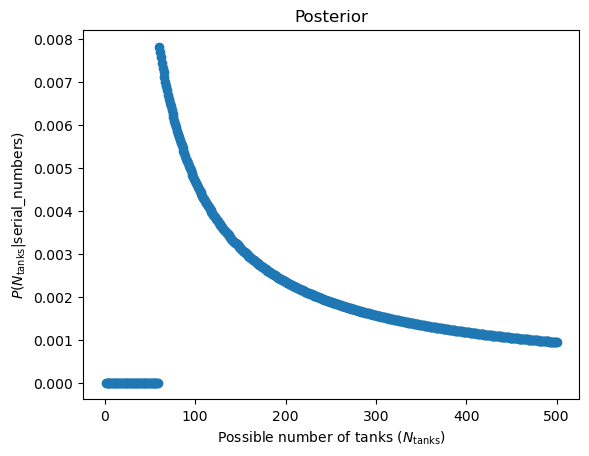

In [79]:
posterior = Posterior(60, possible_num_tanks,prior)
plt.scatter(possible_num_tanks,posterior)
plt.title("Posterior")
plt.ylabel(r"$P(N_\text{tanks} | \text{serial\_numbers})$")
plt.xlabel(r"Possible number of tanks ($N_\text{tanks}$)")

For now, we have only defined the values for a single observed (data) serial number. To account for all observations, we need to update the probabilities one by one sequentially based on the observed serial numbers.

This is done by having first an initial prior distribution (which we set a while ago as uniform distribution), then computing the posterior distribution based on the first data point, which we have also done in the previous cells. To update the probabilities, we simply use the current posterior as the prior for the next data point. After doing this sequential update for all the data points, we obtain the final posterior probability distribution.

In [80]:
###############################################################
# TODO-04: Implement the function that sequentially updates   #
# the posterior distribution based on a given sequence of     #
# data.                                                       #
###############################################################
def Update_Sequence(data_sequence, possible_num_tanks, prior):
    posterior = prior
    for observed_serial in data_sequence:
        posterior = Posterior([observed_serial], possible_num_tanks, posterior)
    return posterior
###############################################################
#                    End of your code.                        #
###############################################################

Text(0.5, 0, 'Possible number of tanks ($N_\\text{tanks}$)')

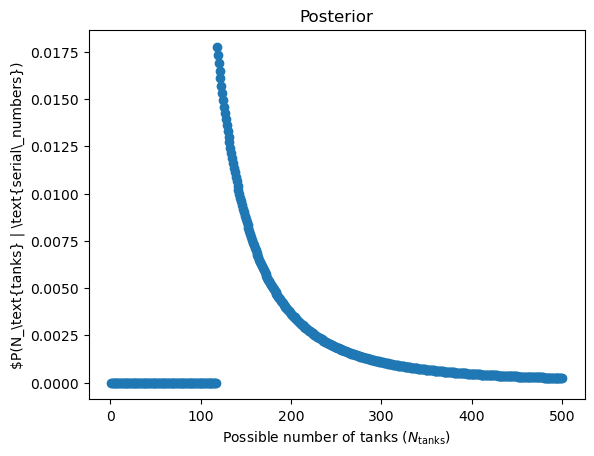

In [81]:
updated_posterior = Update_Sequence(serial_number_captured,possible_num_tanks,prior)
plt.scatter(possible_num_tanks,updated_posterior)
plt.title("Posterior")
plt.ylabel(r"$P(N_\text{tanks} | \text{serial\_numbers})")
plt.xlabel(r"Possible number of tanks ($N_\text{tanks}$)")

Now that we have an updated posterior distribution, we can obtain an estimate of the count by getting the expected value or weighted mean over the possible number of tanks weighted by their posterior probabilities.

$$\mathbb{E}[x] = \sum_x x p(x)$$

In [82]:
###############################################################
# TODO-05: Implement the function that computes for the       #
# expected value.                                             #
###############################################################
def compute_expected_value(possible_num_tanks, posterior):
    expected_value = np.sum(possible_num_tanks * posterior)
    return expected_value

###############################################################
#                    End of your code.                        #
###############################################################

In [83]:
updated_posterior = Update_Sequence(serial_number_captured,possible_num_tanks,prior)
estimated_num_tanks = compute_expected_value(possible_num_tanks , updated_posterior)
print("The estimated number of tanks is", estimated_num_tanks)

The estimated number of tanks is 190.32173365743157


The uniform prior is a prior we use if we do not have any other insights into the distributions. However, we do have some insights in the sense that tanks are expensive to produce. Therefore, the probability of having a small number of tanks is big and the probability of having a large number of tanks is small. 

For this, we can use a power law distribution as defined below:
$$P( N_\text{tanks}) = N_\text{tanks}^{-\alpha}$$

<center>
    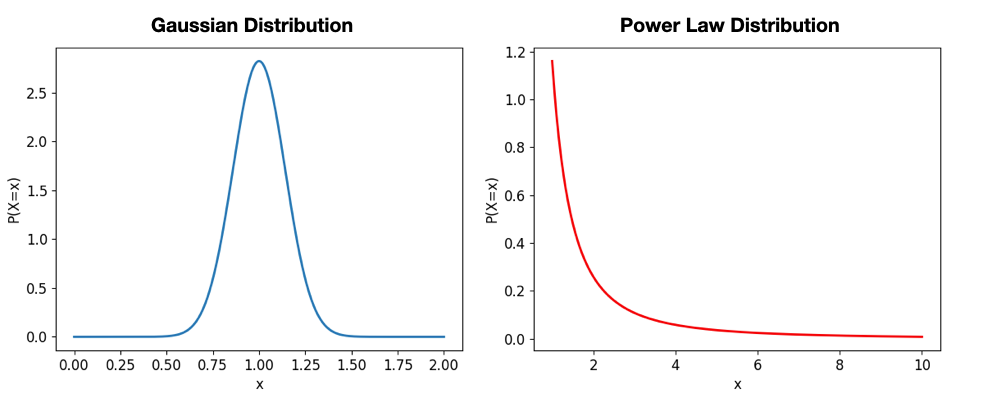
</center>

In [84]:
alpha = 1.0


###############################################################
# TODO-06: Compute for the prior distribution that follows    #
# the power law distribution.                                 #
###############################################################
# unnormalized_prior = possible_num_tanks ** (-alpha)

# Normalize the prior distribution to sum up to 1
# prior_power_law = unnormalized_prior / np.sum(unnormalized_prior)
prior_power_law = possible_num_tanks ** (-alpha)

###############################################################
#                    End of your code.                        #
###############################################################


In [85]:
updated_posterior = Update_Sequence(serial_number_captured,possible_num_tanks,prior_power_law)
estimated_num_tanks = compute_expected_value(possible_num_tanks, updated_posterior)
print("The estimated number of tanks is", estimated_num_tanks)

The estimated number of tanks is 168.7220532183313


<span style='color:red'>**TODO-07:**</span> Plot the estimates of using uniform distribution prior as compared with the estimates from power law distribution prior as the number of captured tanks increase (from 1 to 30).

You can add as many cells below as necessary.

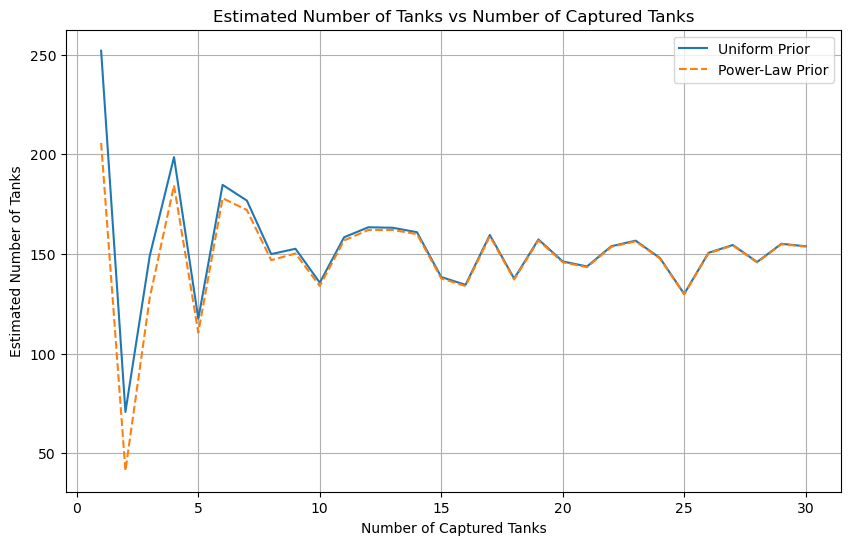

In [86]:
# Define a function to compute estimates for varying numbers of captured tanks
def plot_estimates_comparison(max_captured, possible_num_tanks, uniform_prior, power_law_prior):
    uniform_estimates = []
    power_law_estimates = []

    for num_captured in range(1, max_captured + 1):
        # Randomly sample captured tanks
        captured_samples = np.random.randint(num_tanks, size=(num_captured,)) + 1
        
        # Update posteriors
        uniform_posterior = Update_Sequence(captured_samples, possible_num_tanks, uniform_prior)
        power_law_posterior = Update_Sequence(captured_samples, possible_num_tanks, power_law_prior)

        # Compute expected values
        uniform_estimates.append(compute_expected_value(possible_num_tanks, uniform_posterior))
        power_law_estimates.append(compute_expected_value(possible_num_tanks, power_law_posterior))

    # Plot the comparison
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_captured + 1), uniform_estimates, label="Uniform Prior")
    plt.plot(range(1, max_captured + 1), power_law_estimates, label="Power-Law Prior", linestyle="--")
    plt.title("Estimated Number of Tanks vs Number of Captured Tanks")
    plt.xlabel("Number of Captured Tanks")
    plt.ylabel("Estimated Number of Tanks")
    plt.legend()
    plt.grid()
    plt.show()

# Call the function with your parameters
max_captured = 30
plot_estimates_comparison(max_captured, possible_num_tanks, prior, prior_power_law)


<span style='color:red'>**Question 01:**</span> Compare the two prior distributions. which prior has better estimates in low data regime, in the high data regime?

<span style='color:red'>**A01:**</span> The Uniform Prior tends to overestimate and the Power-Law tends to underestimate. Which prior is better depends heavily on the data that we have obtained. More specifically, it is depended on the tanks that have been captured and which serial number they have. This grants valueble information. We clearly see that as the number of captured tanks increases, both distributions will converge to an equilibrium which is very close to the real answer of 150 tanks. These results coincide with experimentation if we increase our number of captured tanks at beginning of the exercise. 

# (Optimization) Vehicle Routing Problem using OR-tools

In this exercise, you will tackle the Vehicle Routing Problem (VRP) using Google's OR-Tools, a powerful optimization library. The VRP aims to determine the most efficient routes for a fleet of vehicles to deliver goods to multiple locations, minimizing travel distance, time, or cost while adhering to constraints like vehicle capacity and delivery time windows. As a simplification, you will only be implementing a basic VRP with the number of vehicles but without any of the other constraints such as on capacity and delivery time windows. Using OR-Tools, you’ll implement the optimization algorithm to find the best set of routes for all vehicles. This exercise gives practical experience in solving optimization problems, particularly in the logistics domain.

To install OR-Tools, you need to run the following command:

`pip install ortools`

To simplify the problem, we define the delivery addresses and depot location as (x, y) points in a Euclidean space. Another simplification is that we won't be using any road networks and just compute distances using euclidean distances of the points.

In [87]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

In [88]:
delivery_address_points = np.array([[1136,   32],[1387,   46],[ 498,   76],[ 361,   77],[ 360,   78],[ 654,   85],[ 765,  106],[ 956,  113],[ 633,  178],[1361,  197],[ 334,  218],[ 614,  249],[ 432,  319],[ 535,  325],[1316,  334],[1148,  335],[ 871,  342],[1221,  352],[1315,  373],[1171,  407],[ 880,  415],[1064,  415],[1261,  488],[ 810,  523],[ 112,  524],[1342,  571],[ 702,  609],[ 198,  633],[ 890,  669],[ 623,  690],[  88,  700],[ 128,  723],[1531,  731],[1312,  739],[1345,  764],[ 389,  828],[1421,  835],[ 577,  917],[1254,  934],[ 719,  943],[ 382,  951],[ 513,  977],[1087, 1003],[1031, 1038],[ 595, 1046],[ 512, 1057],[ 906, 1064],[ 773, 1100],])
depot_location = np.array([1213,701])

In [89]:
image = cv2.imread("map.png")
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

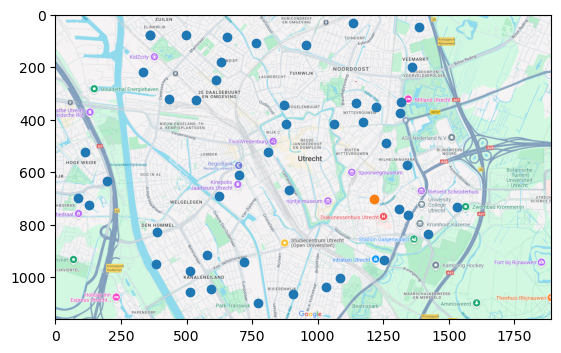

In [90]:
plt.imshow(image)
plt.scatter(delivery_address_points[:,0], delivery_address_points[:,1])
plt.scatter(depot_location[0],depot_location[1])

<span style='color:red'>**TODO-08:**</span> Follow the tutorial page on vehicle routing problem in OR-tools to generate the VRP solutions.

Here's a link to the OR-tools tutorial on vehicle routing problem. 

Link: https://developers.google.com/optimization/routing/vrp

You may add as many cells below as necessary.

Hint: The distance matrix should be converted to integers.

In [91]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))

# Calculate full distance matrix including depot
all_points = np.vstack((depot_location, delivery_address_points))
distance_matrix = np.zeros((all_points.shape[0], all_points.shape[0]))

for i in range(all_points.shape[0]):
    for j in range(all_points.shape[0]):
        distance_matrix[i, j] = euclidean_distance(all_points[i], all_points[j])

# Round the distance matrix to integers
distance_matrix = np.round(distance_matrix).astype(int)
distance_matrix

array([[   0,  673,  678, ...,  786,  475,  594],
       [ 673,    0,  251, ..., 1200, 1057, 1128],
       [ 678,  251,    0, ..., 1337, 1126, 1220],
       ...,
       [ 786, 1200, 1337, ...,    0,  394,  265],
       [ 475, 1057, 1126, ...,  394,    0,  138],
       [ 594, 1128, 1220, ...,  265,  138,    0]])

In [92]:
def create_data_model(distance_matrix, num_vehicles):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    return data

# Start with 4 vehicles
num_vehicles = 4 

data = create_data_model(distance_matrix=distance_matrix, num_vehicles=num_vehicles)

# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

# Create Routing Model
routing = pywrapcp.RoutingModel(manager)

In [93]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["distance_matrix"][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [94]:
dimension_name = "Distance"
routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    9000000000,  # vehicle maximum travel distance we taking a random very large number to indicate it is infinite
    True,  # start cumul to zero
    dimension_name,
)
distance_dimension = routing.GetDimensionOrDie(dimension_name)
distance_dimension.SetGlobalSpanCostCoefficient(100)

In [95]:
# Define search parameters
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)
search_parameters.time_limit.seconds = 10

In [96]:
# Print solution
def print_solution(manager, routing, solution):
    list_route_distance = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} ->'.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        list_route_distance.append(route_distance)
        plan_output += ' {}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
    print('Sum of the route distances: {}m'.format(sum(list_route_distance)))
    return list_route_distance

if solution:
    list_route_distance = print_solution(manager, routing, solution)
else:
    print('No solution found !')

Route for vehicle 0:
 0 -> 43 -> 44 -> 47 -> 48 -> 40 -> 45 -> 46 -> 42 -> 38 -> 30 -> 27 -> 24 -> 16 -> 18 -> 20 -> 23 -> 0
Distance of the route: 2596m

Route for vehicle 1:
 0 -> 22 -> 8 -> 1 -> 2 -> 10 -> 15 -> 19 -> 26 -> 33 -> 37 -> 39 -> 35 -> 34 -> 0
Distance of the route: 2560m

Route for vehicle 2:
 0 -> 41 -> 36 -> 32 -> 31 -> 25 -> 28 -> 0
Distance of the route: 2652m

Route for vehicle 3:
 0 -> 21 -> 17 -> 12 -> 9 -> 7 -> 6 -> 3 -> 4 -> 5 -> 11 -> 13 -> 14 -> 29 -> 0
Distance of the route: 2621m

Sum of the route distances: 10429m


<span style='color:red'>**TODO-09:**</span> Once you have obtained the solution, plot the routes in the map where each vehicle is a different color.

Here's an article showing how to draw arrows using matplotlib.

https://www.geeksforgeeks.org/matplotlib-pyplot-arrow-in-python/

C:\Users\ningw\AppData\Local\Temp\ipykernel_24032\1674104131.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", routing.vehicles())


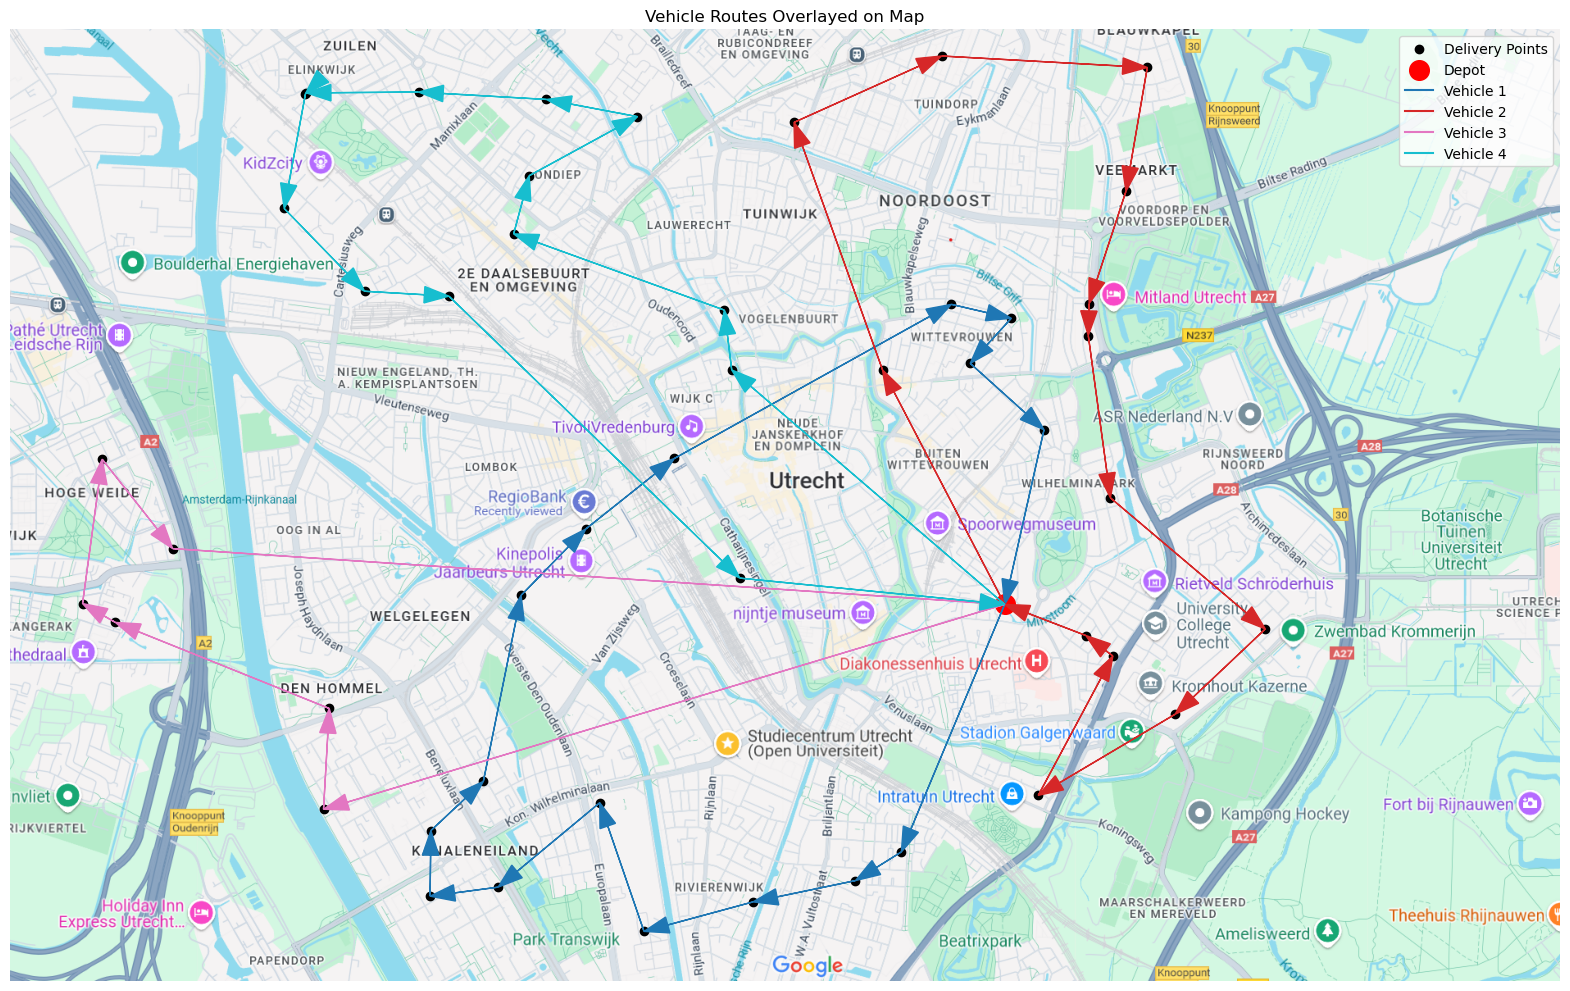

In [97]:
# plt.figure(figsize=(20,20))
# plt.imshow(image)
# plt.scatter(delivery_address_points[:,0], delivery_address_points[:,1])
# plt.scatter(depot_location[0],depot_location[1])

###############################################################
# TODO-10: Draw the trajectory of the vehicles using arrows.  #
# Use a different color for each vehicle.                     #
###############################################################

# Function to plot routes on your existing map
def plot_routes_on_existing_map(solution, manager, routing, locations, depot_index, image):
    plt.figure(figsize=(20, 20))  # Keep your map's size consistent
    plt.imshow(image)  # Display the map image
    plt.scatter(locations[1:, 0], locations[1:, 1], c='black', label='Delivery Points', zorder=5)  # Plot delivery points
    plt.scatter(locations[depot_index, 0], locations[depot_index, 1], c='red', label='Depot', s=200, zorder=5)  # Plot depot
    # plt.figure(figsize=(20,20))
    # plt.imshow(image)
    # plt.scatter(delivery_address_points[:,0], delivery_address_points[:,1])
    # plt.scatter(depot_location[0],depot_location[1])

    # Create a colormap to assign unique colors to each vehicle
    colors = plt.cm.get_cmap("tab10", routing.vehicles())

    # Add vehicle routes and colors to the legend
    for vehicle_id in range(routing.vehicles()):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            index = solution.Value(routing.NextVar(index))

        # Add the depot as the final destination in the route
        route.append(depot_index)

        # Overlay the vehicle routes with arrows
        for i in range(len(route) - 1):
            start = locations[route[i]]
            end = locations[route[i + 1]]
            color = colors(vehicle_id)  # Assign a unique color for each vehicle
            plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
                      color=color, head_width=20, length_includes_head=True, zorder=10)

        # Add to legend
        plt.plot([], [], color=color, label=f'Vehicle {vehicle_id + 1}', zorder=10)

    plt.title("Vehicle Routes Overlayed on Map")
    plt.legend()
    plt.axis("off")  # Remove axes for a cleaner look
    plt.show()

# Call the function
if solution:
    plot_routes_on_existing_map(solution, manager, routing, all_points, depot_index=0, image=image)
else:
    print("No solution found to plot.")


###############################################################
#                    End of your code.                        #
###############################################################


<span style='color:red'>**TODO-11:**</span> 

<span style='color:red'>**Question 02:**</span> What is the optimal number of vehicles that the company needs to operate in order to deliver to all the locations at the lowest cost assuming that the employee for each vehicle are paid 30 euros per hour, drive at approximately 80 km/h and fuel cost 0.11 euros per kilometer?
Note that the coordinates provided are not to scale. Assume that there is a 100x scale difference to actual road distances.
(You may add as many cells below as necessary to perform the experiments in order to justify your answer.)

<span style='color:red'>**A02:**</span>

In [ ]:
list_dist_run = []
for num_vehicles in range(1,7):
    data = create_data_model(distance_matrix=distance_matrix, num_vehicles=num_vehicles)
    print(f"Run with {num_vehicles} vehicles")
    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # Create Routing Model
    routing = pywrapcp.RoutingModel(manager)
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    dimension_name = "Distance"
    routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    9000000000,  # vehicle maximum travel distance choosing an arbitrary large number to indicate no constraint
    True,  # start cumul to zero
    dimension_name,
)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    # Define search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.time_limit.seconds = 10 

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        list_route_distance2 = print_solution(manager, routing, solution)
        list_dist_run.append(list_route_distance2)
        print()
    else:
        list_dist_run.append([999999]) #give it a very high penalty when we can't find a solution within 10 seconds
        print('No solution found !')

Run with 1 vehicles
Route for vehicle 0:
 0 -> 34 -> 35 -> 37 -> 33 -> 26 -> 23 -> 19 -> 15 -> 10 -> 2 -> 1 -> 8 -> 7 -> 6 -> 9 -> 12 -> 14 -> 13 -> 3 -> 4 -> 5 -> 11 -> 25 -> 28 -> 31 -> 32 -> 36 -> 41 -> 42 -> 46 -> 45 -> 38 -> 30 -> 27 -> 24 -> 21 -> 17 -> 16 -> 18 -> 20 -> 22 -> 29 -> 40 -> 48 -> 47 -> 44 -> 43 -> 39 -> 0
Distance of the route: 7184m

Sum of the route distances: 7184m

Run with 2 vehicles
Route for vehicle 0:
 0 -> 29 -> 21 -> 24 -> 27 -> 30 -> 28 -> 25 -> 31 -> 32 -> 36 -> 41 -> 42 -> 46 -> 45 -> 38 -> 40 -> 48 -> 47 -> 44 -> 43 -> 39 -> 37 -> 0
Distance of the route: 3847m

Route for vehicle 1:
 0 -> 23 -> 20 -> 18 -> 16 -> 22 -> 17 -> 9 -> 12 -> 14 -> 13 -> 11 -> 5 -> 4 -> 3 -> 6 -> 7 -> 8 -> 1 -> 2 -> 10 -> 15 -> 19 -> 26 -> 33 -> 35 -> 34 -> 0
Distance of the route: 3834m

Sum of the route distances: 7681m

Run with 3 vehicles
Route for vehicle 0:
 0 -> 21 -> 9 -> 12 -> 14 -> 13 -> 11 -> 5 -> 4 -> 3 -> 6 -> 7 -> 22 -> 26 -> 33 -> 37 -> 35 -> 34 -> 0
Distance o

In [99]:
list_cost = []
for i in list_dist_run:
    total_cost = 0
    list_cost_per_employee = []
    for j in i:
        # Calculate costs
        hours_needed = j*100 / (80*1000)  #scale is 100, the distance is in meter hence have to divide by 1k
        employee_cost = hours_needed * 30
        fuel_cost = (j*100/1000) * 0.11
        total_cost += employee_cost + fuel_cost
        list_cost_per_employee.append(total_cost)
    list_cost.append(round(sum(list_cost_per_employee),2))

print("List of costs:", list_cost)

# Find the index with the lowest cost
min_cost_index = list_cost.index(min(list_cost))
print(f"Solution with {min_cost_index + 1} vehicles has the lowest cost")
print("Lowest total cost:", list_cost[min_cost_index])


List of costs: [348.42, 559.11, 907.0, 1260.47, 1686.98, 2154.52]
Solution with 1 vehicles has the lowest cost
Lowest total cost: 348.42


<span style='color:red'>**Question 03:**</span> How does the vehicle number change when you factor in that each employee only work 4 hours a day? (You may add as many cells below as necessary to perform the experiments in order to justify your answer.)

<span style='color:red'>**A03:**</span>

In [ ]:
max_dist = int((80*4*1000)/100) #calculate maximal distance each employee can make in 4 hours and keep in mind scaling and convert to meter

list_dist_run = []
for num_vehicles in range(1,7):
    data = create_data_model(distance_matrix=distance_matrix, num_vehicles=num_vehicles)
    print(f"Run with {num_vehicles} vehicles")
    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

    # Create Routing Model
    routing = pywrapcp.RoutingModel(manager)
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    dimension_name = "Distance"
    routing.AddDimension(
    transit_callback_index,
    0,  # no slack
    max_dist,  # vehicle maximum travel distance
    True,  # start cumul to zero
    dimension_name,
)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)
    # Define search parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.time_limit.seconds = 10 

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        list_route_distance2 = print_solution(manager, routing, solution)
        list_dist_run.append(list_route_distance2)
        print()
    else:
        list_dist_run.append([999999]) #give it a very high penalty when we can't find a solution within 10 seconds
        print('No solution found !')

Run with 1 vehicles
No solution found !
Run with 2 vehicles
No solution found !
Run with 3 vehicles
Route for vehicle 0:
 0 -> 21 -> 9 -> 12 -> 14 -> 13 -> 11 -> 5 -> 4 -> 3 -> 6 -> 7 -> 8 -> 1 -> 2 -> 10 -> 15 -> 19 -> 0
Distance of the route: 3075m

Route for vehicle 1:
 0 -> 39 -> 43 -> 44 -> 47 -> 48 -> 45 -> 46 -> 42 -> 41 -> 36 -> 32 -> 31 -> 25 -> 28 -> 30 -> 29 -> 0
Distance of the route: 3023m

Route for vehicle 2:
 0 -> 34 -> 35 -> 37 -> 33 -> 26 -> 23 -> 20 -> 18 -> 16 -> 22 -> 17 -> 24 -> 27 -> 38 -> 40 -> 0
Distance of the route: 2713m

Sum of the route distances: 8811m

Run with 4 vehicles
Route for vehicle 0:
 0 -> 24 -> 12 -> 14 -> 13 -> 11 -> 5 -> 4 -> 3 -> 9 -> 6 -> 7 -> 17 -> 21 -> 22 -> 0
Distance of the route: 2628m

Route for vehicle 1:
 0 -> 23 -> 20 -> 18 -> 16 -> 8 -> 1 -> 2 -> 10 -> 15 -> 19 -> 26 -> 0
Distance of the route: 1949m

Route for vehicle 2:
 0 -> 41 -> 36 -> 32 -> 31 -> 25 -> 28 -> 0
Distance of the route: 2652m

Route for vehicle 3:
 0 -> 29 -> 27

In [101]:
list_cost = []
for i in list_dist_run:
    total_cost = 0
    list_cost_per_employee = []
    for j in i:
        # Calculate costs
        hours_needed = j*100 / (80*1000)  #scale is 100, the distance is in meter hence have to divide by 1k
        employee_cost = hours_needed * 30
        fuel_cost = (j*100/1000) * 0.11
        total_cost += employee_cost + fuel_cost
        list_cost_per_employee.append(total_cost)
    list_cost.append(round(sum(list_cost_per_employee),2))

print("List of costs:", list_cost)

# Find the index with the lowest cost
min_cost_index = list_cost.index(min(list_cost))
print(f"Solution with {min_cost_index + 1} vehicles has the lowest cost")
print("Lowest total cost:", list_cost[min_cost_index])

List of costs: [48499.95, 48499.95, 872.22, 1178.7, 1348.93, 2275.04]
Solution with 3 vehicles has the lowest cost
Lowest total cost: 872.22


<span style='color:red'>**Question:**</span> How much time did it take you to answer this notebook?

<span style='color:red'>**A:**</span> A few hours. Its really a lot of work!